# Name Fasika Worku
# ID DBUR/1886/12
# Title Movie Dataset

# Import Libraries

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_val_score
import json
from pathlib import Path

# Load datasets from 3 different data sources in 3 different formats like CSV,XSL and JSON and merge them.

In [3]:
# Load the CSV file
csv_file_path = Path(r'C:\Users\hp\Downloads\tmdb-movies (1).csv')
df_csv = pd.read_csv(csv_file_path)

# Load the Excel file
excel_file_path = Path(r'C:\Users\hp\Downloads\movies (2).xls')
df_excel = pd.read_excel(excel_file_path)

# Load the JSON file
json_file_path = Path(r'C:\Users\hp\Downloads\406b843afdfb9c6a86e25753fe2761f4-523c324c7fcc36efab8224f9ebb7556c09b69a14\Film.JSON')
with open(json_file_path) as json_file:
  data_json = json.load(json_file)
df_json = pd.json_normalize(data_json)

In [4]:
# Concatenate the dataframes vertically
df_combined = pd.concat([df_csv, df_excel, df_json], ignore_index=True)

# Display the combined dataframe
print(df_combined.head())

         id    imdb_id  popularity       budget       revenue  \
0  135397.0  tt0369610   32.985763  150000000.0  1.513529e+09   
1   76341.0  tt1392190   28.419936  150000000.0  3.784364e+08   
2  262500.0  tt2908446   13.112507  110000000.0  2.952382e+08   
3  140607.0  tt2488496   11.173104  200000000.0  2.068178e+09   
4  168259.0  tt2820852    9.335014  190000000.0  1.506249e+09   

                 original_title  \
0                Jurassic World   
1            Mad Max: Fury Road   
2                     Insurgent   
3  Star Wars: The Force Awakens   
4                     Furious 7   

                                                cast  \
0  Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...   
1  Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...   
2  Shailene Woodley|Theo James|Kate Winslet|Ansel...   
3  Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...   
4  Vin Diesel|Paul Walker|Jason Statham|Michelle ...   

                                            homepage         

# Perform EDA (Exploratory Data Analysis)

In [5]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

# Extract relevant columns for this task
genres_and_year = df_combined[['release_year', 'genres']]

# Handle NaN values in the 'genres' column
df_combined['genres'] = df_combined['genres'].fillna('Unknown')

# Convert 'release_year' to numeric, replace NaN values with 0, and then convert to integer
df_combined['release_year'] = pd.to_numeric(df_combined['release_year'], errors='coerce').fillna(0).astype(int)

# Create a MultiLabelBinarizer to one-hot encode genres
mlb = MultiLabelBinarizer()
genre_matrix = pd.DataFrame(mlb.fit_transform(df_combined['genres'].str.split('|')), columns=mlb.classes_)

# Concatenate one-hot encoded genres with the original dataframe
df = pd.concat([df_combined, genre_matrix], axis=1)




# Which genres are most popular from year to year?

In [6]:
# Get the count of genre for each year
genre_counts = df.groupby('release_year')['genres'].apply(lambda x: pd.Series(x.str.split('|').sum()).value_counts())

# Get the most popular genre for each year
most_popular_genres = genre_counts.groupby(level=0).idxmax()

print("Most popular genres from year to year:")
print(most_popular_genres)

Most popular genres from year to year:
release_year
0         (0, Unknown)
1960     (1960, Drama)
1961     (1961, Drama)
1962     (1962, Drama)
1963     (1963, Drama)
1964     (1964, Drama)
1965     (1965, Drama)
1966    (1966, Comedy)
1967    (1967, Comedy)
1968     (1968, Drama)
1969     (1969, Drama)
1970     (1970, Drama)
1971     (1971, Drama)
1972     (1972, Drama)
1973     (1973, Drama)
1974     (1974, Drama)
1975     (1975, Drama)
1976     (1976, Drama)
1977     (1977, Drama)
1978     (1978, Drama)
1979     (1979, Drama)
1980     (1980, Drama)
1981     (1981, Drama)
1982     (1982, Drama)
1983     (1983, Drama)
1984     (1984, Drama)
1985    (1985, Comedy)
1986     (1986, Drama)
1987    (1987, Comedy)
1988    (1988, Comedy)
1989    (1989, Comedy)
1990     (1990, Drama)
1991     (1991, Drama)
1992     (1992, Drama)
1993     (1993, Drama)
1994    (1994, Comedy)
1995     (1995, Drama)
1996     (1996, Drama)
1997     (1997, Drama)
1998     (1998, Drama)
1999     (1999, Drama)
2000 

# Plot the most popular genres each year

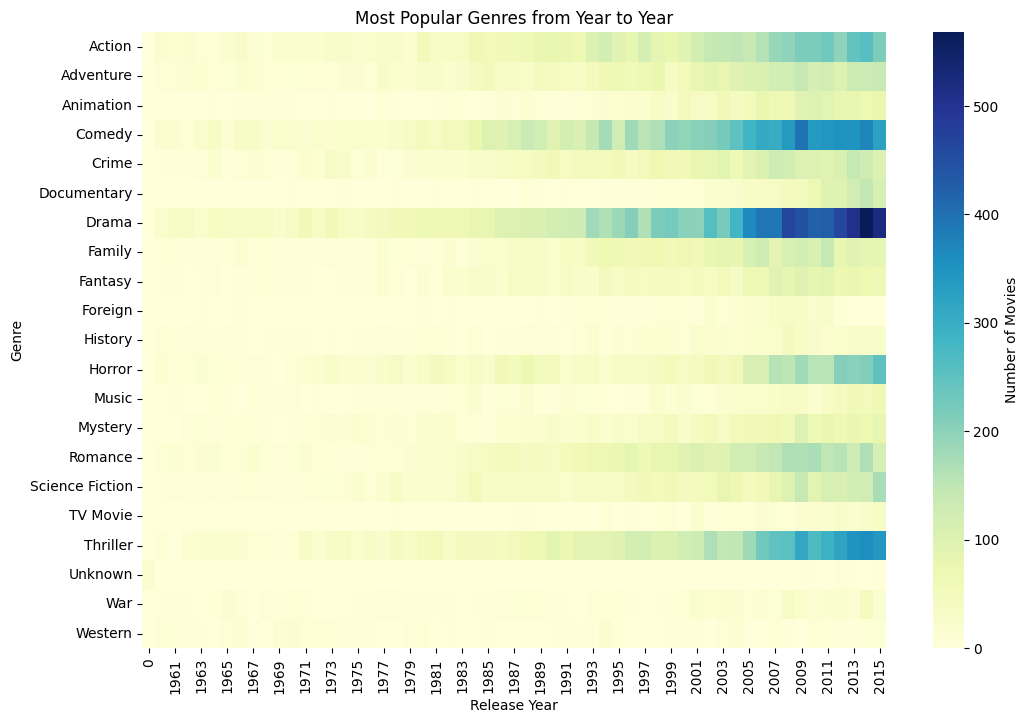

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# 'genres' is a column containing a list of genres for each movie
# Split the genres in each row and explode them into separate rows
df_genres_expanded = df['genres'].str.split('|', expand=True).stack().reset_index(level=1, drop=True).reset_index(name='genre')

# Merge the expanded genres back with the original dataframe
df_combined_genres_expanded = df.merge(df_genres_expanded, left_index=True, right_index=True)

# Handle non-integer values in 'release_year' by replacing with NaN
df_combined_genres_expanded['release_year'] = pd.to_numeric(df_combined_genres_expanded['release_year'], errors='coerce')

# Replace NaN values with 0 (or any default value)
df_combined_genres_expanded['release_year'] = df_combined_genres_expanded['release_year'].fillna(0).astype(int)

# Group by release year and genre, then sum up the genre occurrences
genre_popularity_by_year = df_combined_genres_expanded.groupby('release_year')[mlb.classes_].sum()

# Plot the most popular genres each year
plt.figure(figsize=(12, 8))
sns.heatmap(genre_popularity_by_year.T, cmap="YlGnBu", cbar_kws={'label': 'Number of Movies'})
plt.title('Most Popular Genres from Year to Year')
plt.xlabel('Release Year')
plt.ylabel('Genre')
plt.show()


# What kinds of properties are associated with movies that have high revenues?

In [8]:
# 1. Explore the Data
pd.options.display.float_format = '{:,.2f}'.format  # Set the float format to display without scientific notation
print("Descriptive Statistics of Revenue:")
print(df['revenue'].describe())


Descriptive Statistics of Revenue:
count          21,732.00
mean       39,823,319.79
std       117,000,794.46
min                 0.00
25%                 0.00
50%                 0.00
75%        24,000,000.00
max     2,781,505,847.00
Name: revenue, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\165821253.py:7: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_success = df_combined[['budget', 'genres', 'release_date', 'runtime', 'cast', 'vote_average', 'popularity', 'revenue']].corr()


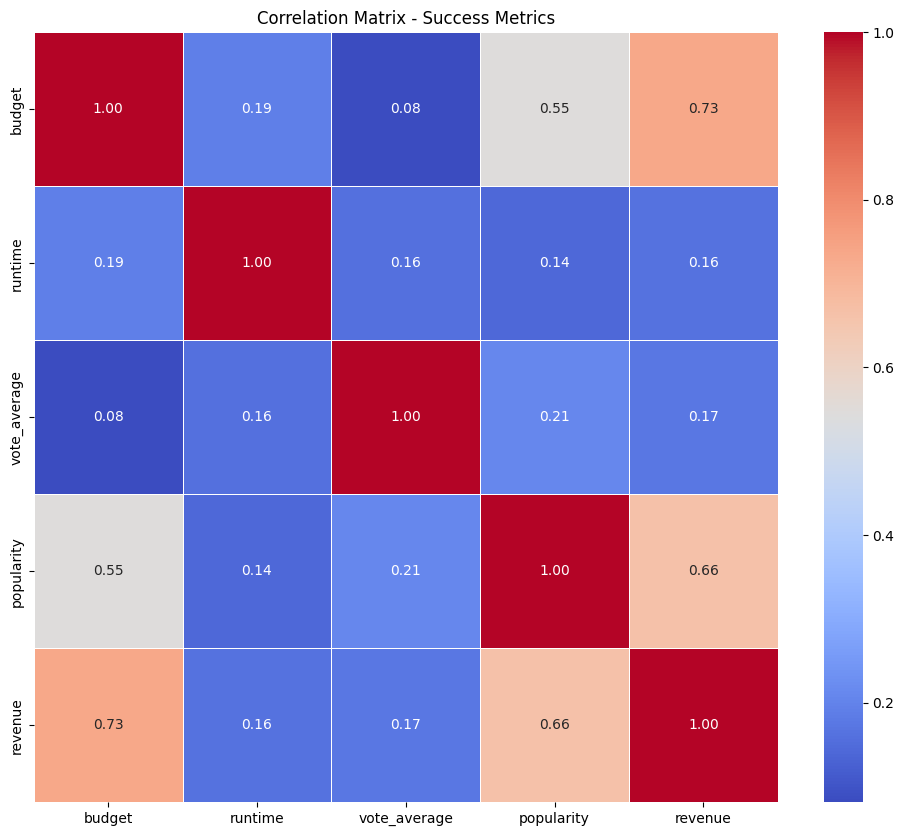

In [9]:
#2 Displaying correlation with revenue
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Explore correlations between features and success metrics
correlation_success = df_combined[['budget', 'genres', 'release_date', 'runtime', 'cast', 'vote_average', 'popularity', 'revenue']].corr()

# Visualize correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_success, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix - Success Metrics')
plt.show()


In [11]:
print(correlation_success.head())

              budget  runtime  vote_average  popularity  revenue
budget          1.00     0.19          0.08        0.55     0.73
runtime         0.19     1.00          0.16        0.14     0.16
vote_average    0.08     0.16          1.00        0.21     0.17
popularity      0.55     0.14          0.21        1.00     0.66
revenue         0.73     0.16          0.17        0.66     1.00


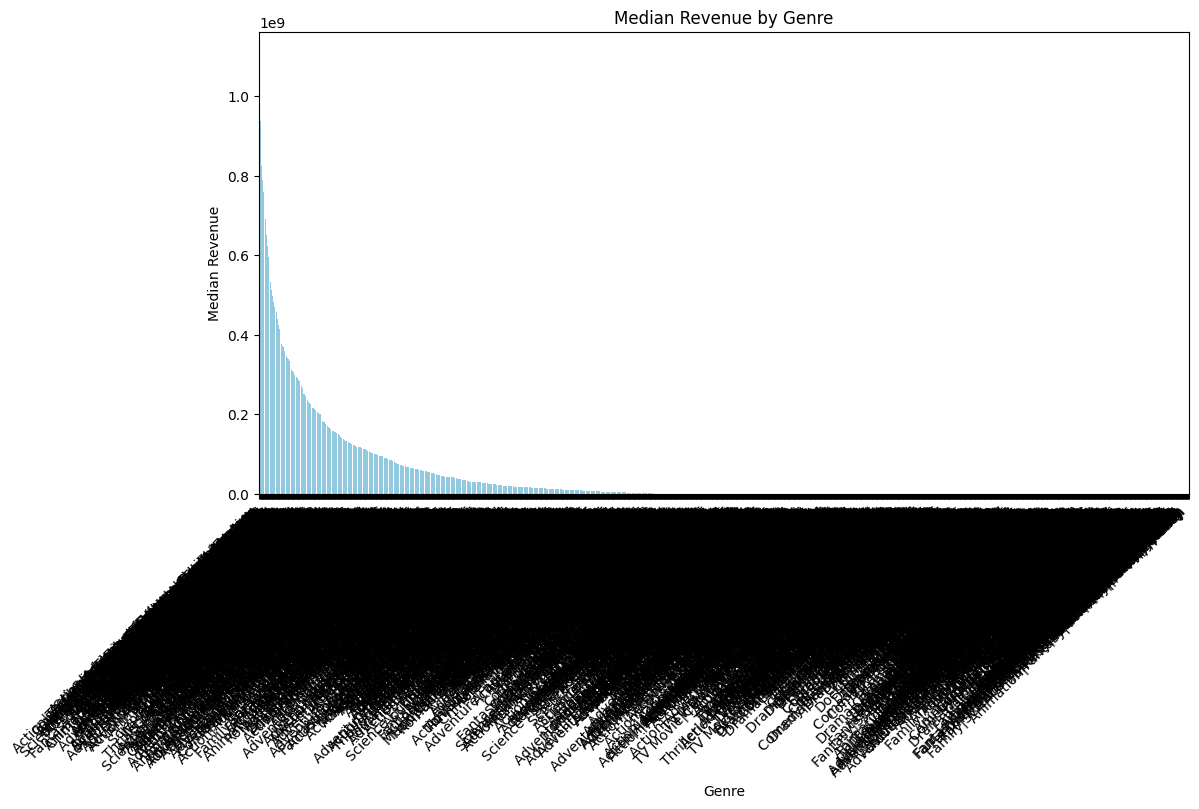

In [10]:
# 3. Genre Analysis
# Split genres and create binary columns for each genre
genres_split = df['genres'].str.get_dummies('|')

# Concatenate the binary genre columns with the original dataframe
df = pd.concat([df, genres_split], axis=1)

# Analyze the impact of each genre on revenue
genre_revenue_analysis = df.groupby('genres')['revenue'].median().sort_values(ascending=False)

# Plotting genre vs. median revenue with a lighter color
plt.figure(figsize=(12, 6))
sns.barplot(x=genre_revenue_analysis.index, y=genre_revenue_analysis.values, color='skyblue')  
plt.title('Median Revenue by Genre')
plt.xlabel('Genre')
plt.ylabel('Median Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


In [12]:
print(genre_revenue_analysis.head())

genres
Crime|Drama|Mystery|Thriller|Action         1,106,279,658.00
Action|Adventure|Science Fiction|Fantasy    1,034,089,112.50
Family|Fantasy|Adventure                    1,025,467,110.00
Adventure|Fantasy|Family|Mystery              938,212,738.00
Science Fiction|Thriller|Action|Adventure     847,423,452.00
Name: revenue, dtype: float64


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\3899639538.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=director_revenue_analysis.index, y=director_revenue_analysis.values, palette='viridis')


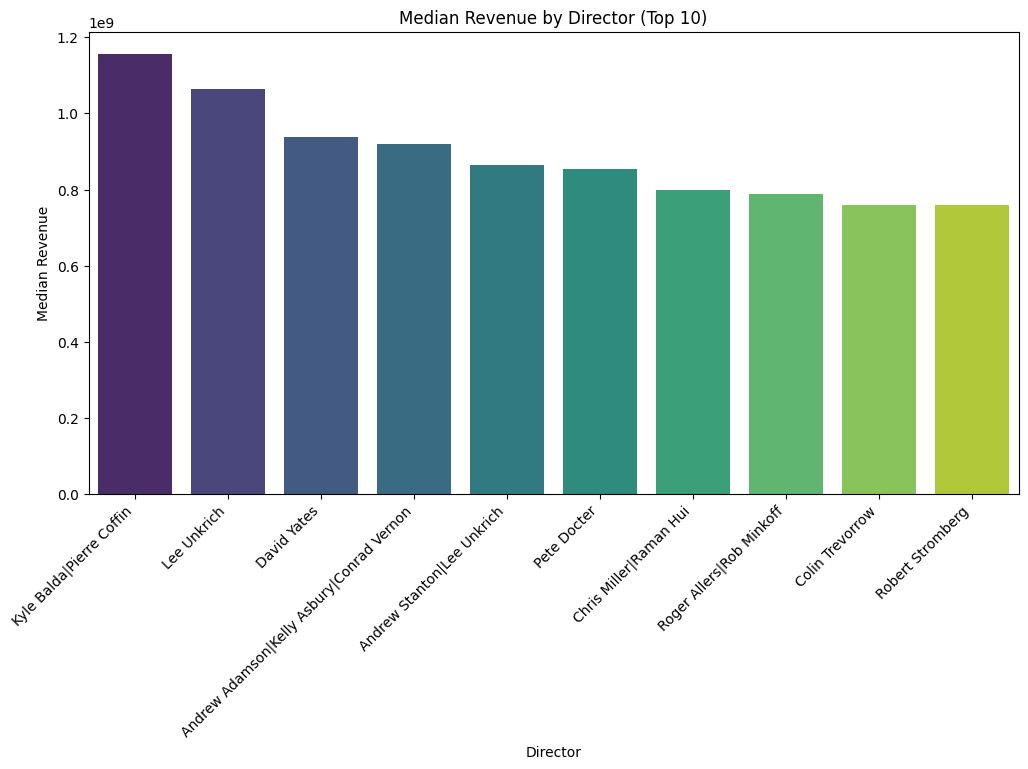

In [13]:
# 4. Analyze the impact of directors on revenue
director_revenue_analysis = df.groupby('director')['revenue'].median().sort_values(ascending=False).head(10)

# Plotting director vs. median revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=director_revenue_analysis.index, y=director_revenue_analysis.values, palette='viridis')
plt.title('Median Revenue by Director (Top 10)')
plt.xlabel('Director')
plt.ylabel('Median Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\586524042.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cast_revenue_analysis.index, y=cast_revenue_analysis.values, palette='viridis')


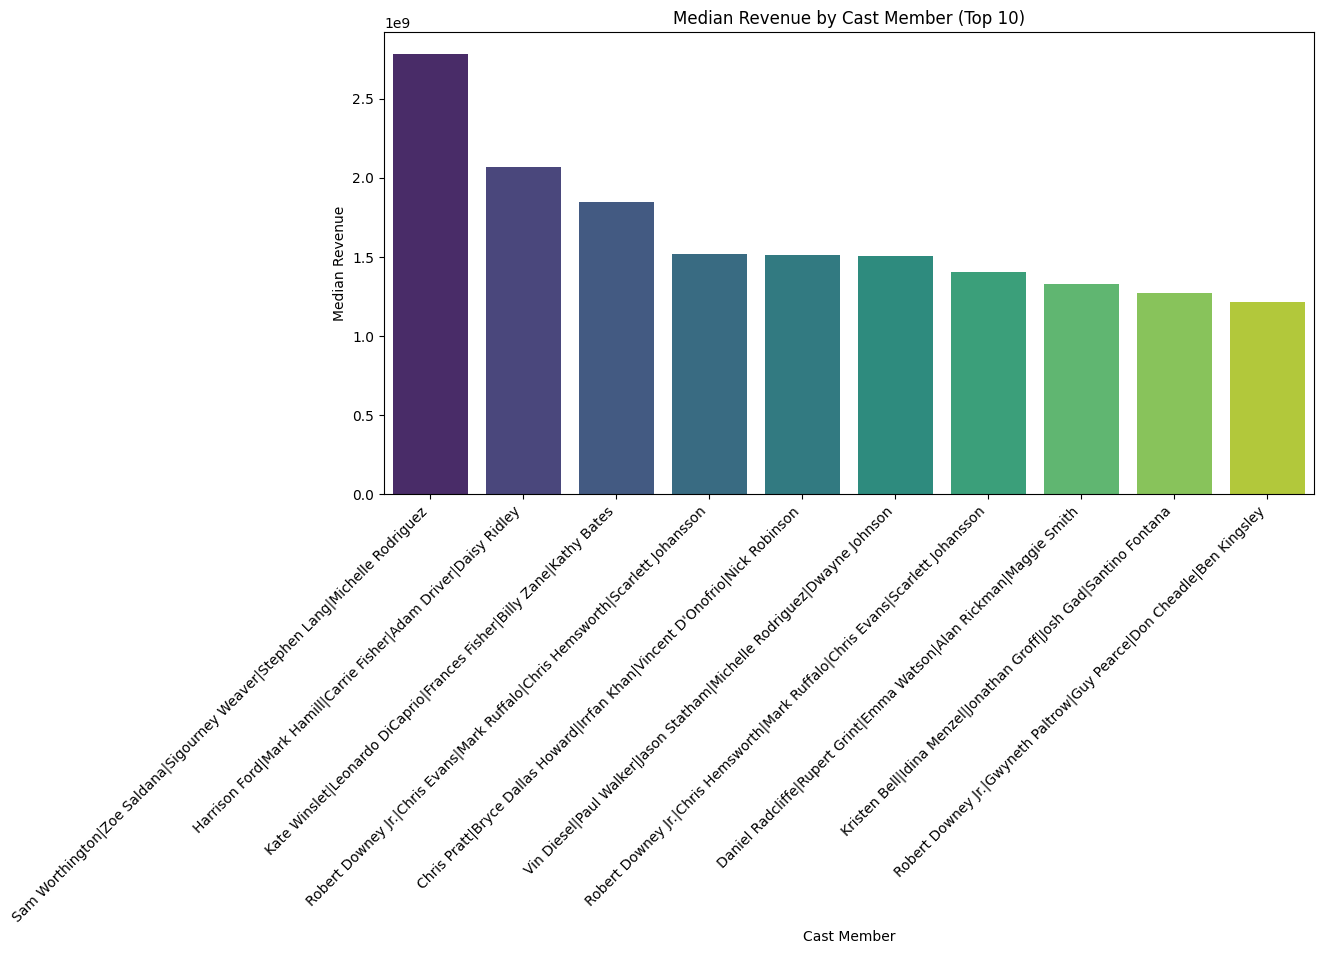

In [14]:

#5 Analyze the impact of cast members on revenue
cast_revenue_analysis = df.groupby('cast')['revenue'].median().sort_values(ascending=False).head(10)

# Plotting cast vs. median revenue
plt.figure(figsize=(12, 6))
sns.barplot(x=cast_revenue_analysis.index, y=cast_revenue_analysis.values, palette='viridis')
plt.title('Median Revenue by Cast Member (Top 10)')
plt.xlabel('Cast Member')
plt.ylabel('Median Revenue')
plt.xticks(rotation=45, ha='right')
plt.show()

Unique Release Months: [ 6.  5.  3. 12.  4.  9. 10.  2.  1.  7. 11.  8. nan]


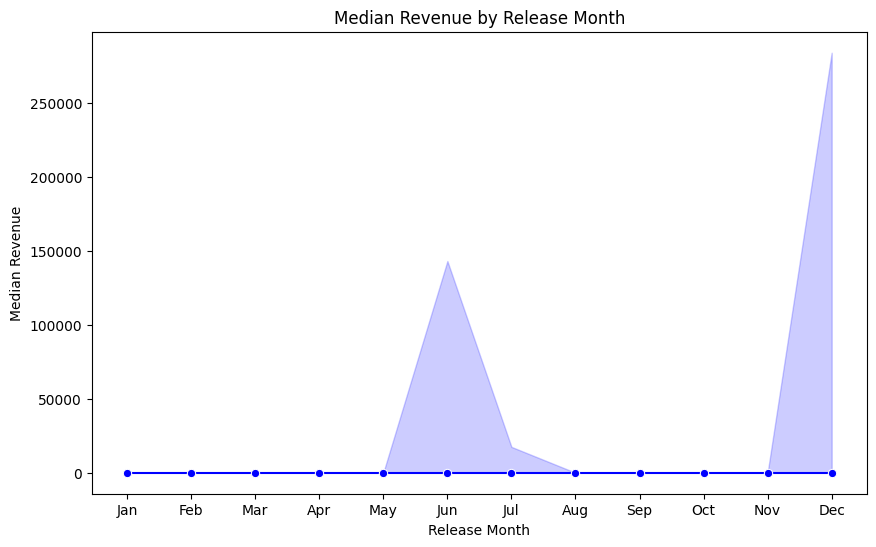

In [15]:
# 6. Release Date Impact
# Extract month from release date and analyze its impact on revenue
df['release_month'] = pd.to_datetime(df['release_date'], errors='coerce').dt.month

# Check unique release months
print("Unique Release Months:", df['release_month'].unique())

# Drop rows with missing or incorrect release months
df = df.dropna(subset=['release_month'])

# Plotting release month vs. median revenue
plt.figure(figsize=(10, 6))
sns.lineplot(x='release_month', y='revenue', data=df, estimator='median', marker='o', color='blue')
plt.title('Median Revenue by Release Month')
plt.xlabel('Release Month')
plt.ylabel('Median Revenue')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

# Analyzing Trends

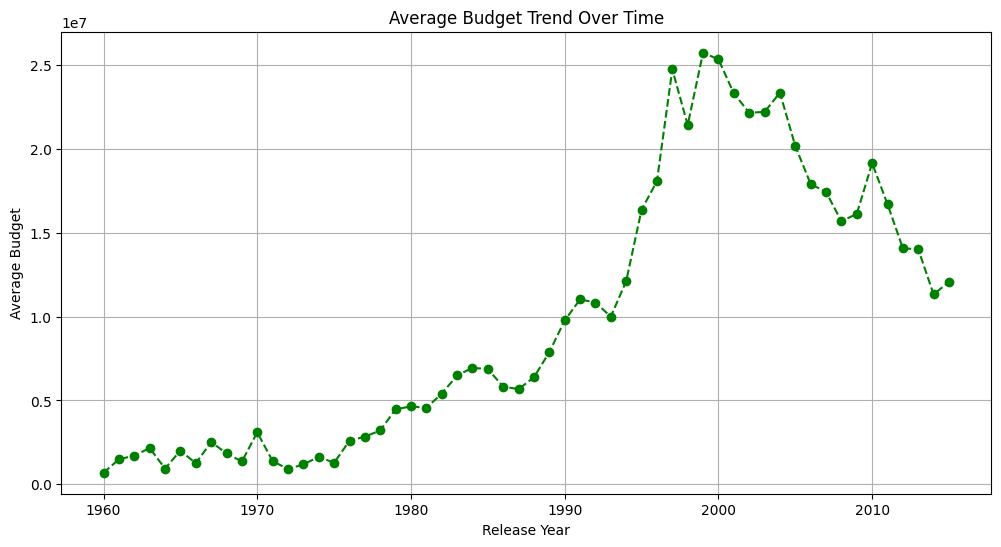

In [16]:
# Explore trends or patterns using scatter plots or boxplots
# Example: Budget vs Popularity
# Change the display format for budget
pd.options.display.float_format = '{:,.2f}'.format

# Analyzing Trends: Release Year vs Average Budget
average_budget_by_year = df.groupby('release_year')['budget'].mean()

plt.figure(figsize=(12, 6))
plt.plot(average_budget_by_year.index, average_budget_by_year.values, marker='o', color='green', linestyle='--')
plt.title('Average Budget Trend Over Time')
plt.xlabel('Release Year')
plt.ylabel('Average Budget')
plt.grid(True)
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\2651481534.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genres', y='revenue', data=df[df['genres'].isin(top_genres)], palette='viridis')


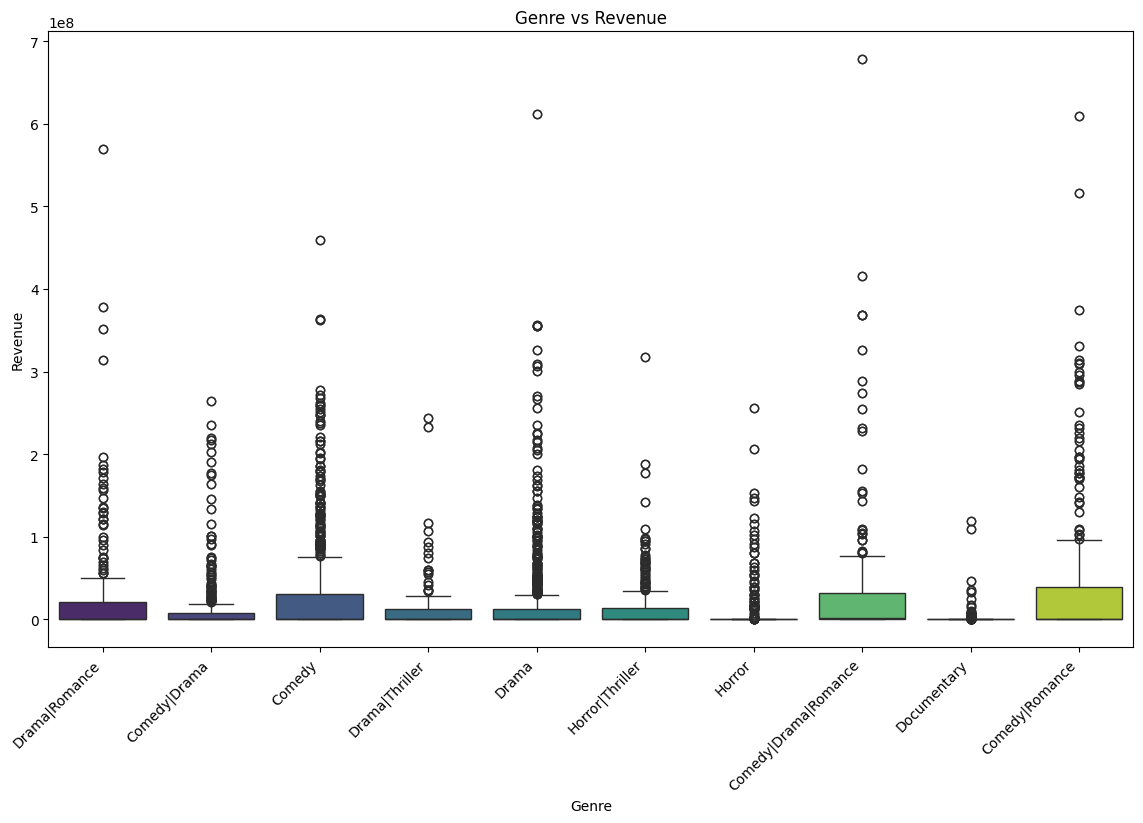

In [17]:
# Example: Genre vs Revenue
plt.figure(figsize=(14, 8))
# Limit the number of displayed genres to the top 10
top_genres = df['genres'].value_counts().nlargest(10).index
sns.boxplot(x='genres', y='revenue', data=df[df['genres'].isin(top_genres)], palette='viridis')
plt.title('Genre vs Revenue')
plt.xlabel('Genre')
plt.ylabel('Revenue')
plt.xticks(rotation=45, ha='right')  # Rotate genre labels for better readability
plt.show()


# Does the presence of certain actors or actresses correlate with higher revenue or popularity?

C:\Users\hp\AppData\Local\Temp\ipykernel_3432\2895111802.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='revenue', y='cast', data=top_cast_by_revenue, palette='viridis')


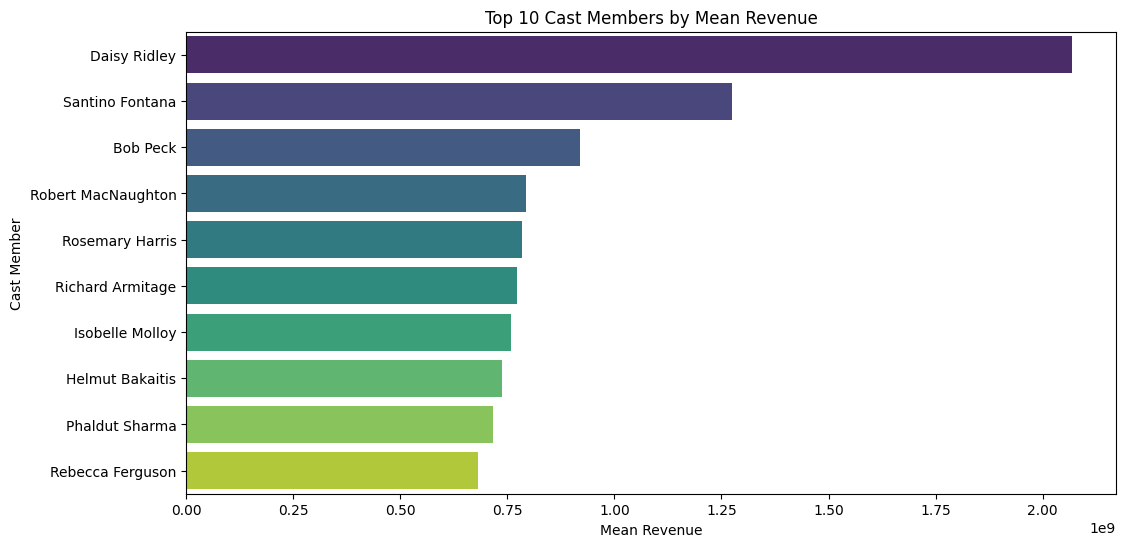

In [18]:
# Let's focus on 'cast', 'revenue', and 'popularity'
casting_data = df[['cast', 'revenue', 'popularity']]

# Drop rows with missing values in 'cast'
casting_data = casting_data.dropna(subset=['cast'])

# Split multiple cast members into separate rows
casting_data = casting_data.assign(cast=casting_data['cast'].str.split('|')).explode('cast')

# Group by each cast member and calculate mean revenue and popularity
cast_influence = casting_data.groupby('cast').agg({'revenue': 'mean', 'popularity': 'mean'}).reset_index()

# Select the top N cast members based on revenue or popularity
top_cast_by_revenue = cast_influence.nlargest(10, 'revenue')
top_cast_by_popularity = cast_influence.nlargest(10, 'popularity')

# Visualize top cast members by revenue
plt.figure(figsize=(12, 6))
sns.barplot(x='revenue', y='cast', data=top_cast_by_revenue, palette='viridis')
plt.title('Top 10 Cast Members by Mean Revenue')
plt.xlabel('Mean Revenue')
plt.ylabel('Cast Member')
plt.show()


C:\Users\hp\AppData\Local\Temp\ipykernel_3432\669905384.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='popularity', y='cast', data=top_cast_by_popularity, palette='plasma')


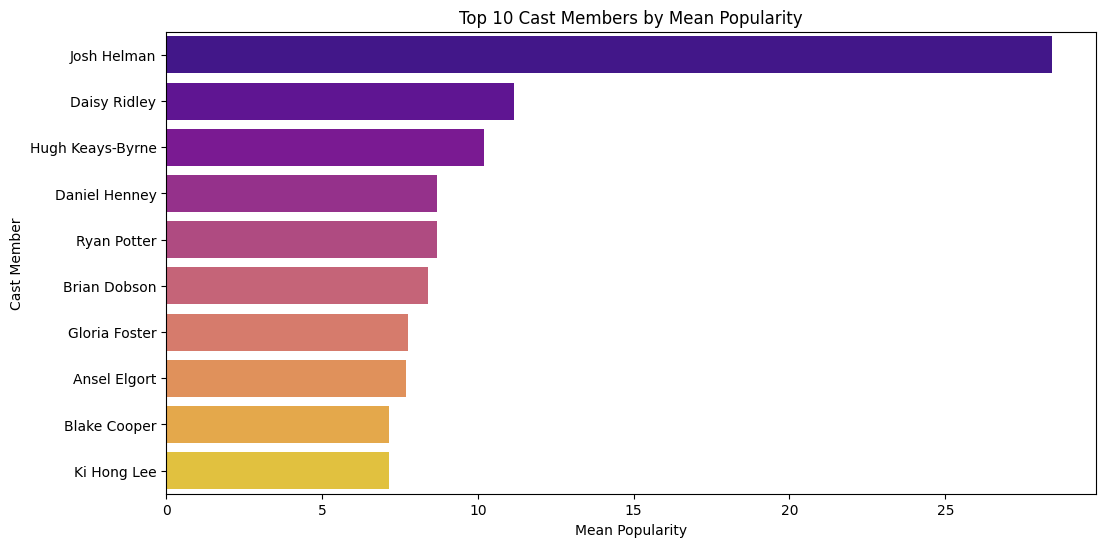

In [19]:
# Visualize top cast members by popularity
plt.figure(figsize=(12, 6))
sns.barplot(x='popularity', y='cast', data=top_cast_by_popularity, palette='plasma')
plt.title('Top 10 Cast Members by Mean Popularity')
plt.xlabel('Mean Popularity')
plt.ylabel('Cast Member')
plt.show()

# Which production companies are associated with the highest-grossing movies?

C:\Users\hp\AppData\Local\Temp\ipykernel_3432\356018366.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='revenue', y='production_companies', data=top_production_companies, palette='mako')


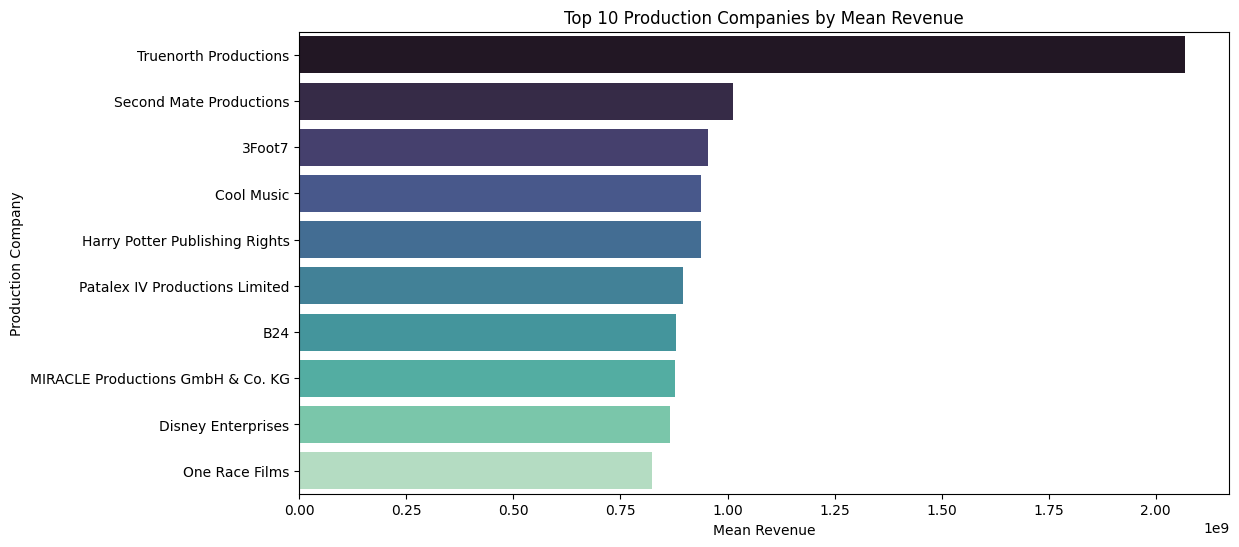

In [20]:
# Let's focus on 'production_companies' and 'revenue'
production_data = df[['production_companies', 'revenue']]

# Drop rows with missing values in 'production_companies'
production_data = production_data.dropna(subset=['production_companies'])

# Split multiple production companies into separate rows
production_data = production_data.assign(production_companies=production_data['production_companies'].str.split('|')).explode('production_companies')

# Group by each production company and calculate mean revenue
top_production_companies = production_data.groupby('production_companies')['revenue'].mean().nlargest(10).reset_index()

# Visualize top production companies
plt.figure(figsize=(12, 6))
sns.barplot(x='revenue', y='production_companies', data=top_production_companies, palette='mako')
plt.title('Top 10 Production Companies by Mean Revenue')
plt.xlabel('Mean Revenue')
plt.ylabel('Production Company')
plt.show()


# Based on the analysis, what are the long-term outlook and projections for the movie industry?
# Using LinearRegression

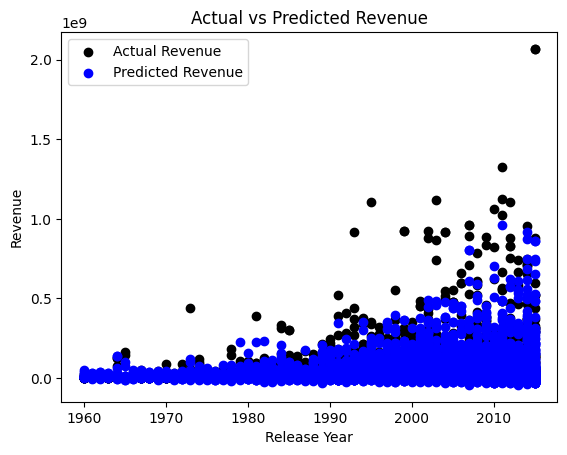

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

# Select relevant features (X) and target variable (y)
features = ['release_year', 'budget', 'popularity', 'vote_average']
target = 'revenue'

X = df[features]
y = df[target]

# Preprocess data: Handle missing values and convert categorical variables if needed
X = X.fillna(0)  # Fill missing values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a Linear Regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Visualize predicted vs actual revenue on the test set
plt.scatter(X_test['release_year'], y_test, color='black', label='Actual Revenue')
plt.scatter(X_test['release_year'], predictions, color='blue', label='Predicted Revenue')
plt.title('Actual vs Predicted Revenue')
plt.xlabel('Release Year')
plt.ylabel('Revenue')
plt.legend()
plt.show()


# Project revenues for the next 10 years

In [27]:
# Project revenues for the next 10 years
future_years = range(int(X['release_year'].max()) + 1, int(X['release_year'].max()) + 11)
future_projections = []

for future_year in future_years:
    # Replace with your own estimates for budget, popularity, and vote_average for the future year
    some_budget_estimate = 10000000  # Replace with your estimate
    some_popularity_estimate = 50  # Replace with your estimate
    some_vote_average_estimate = 7.5  # Replace with your estimate
    
    future_data = pd.DataFrame({'release_year': [future_year], 'budget': [some_budget_estimate], 'popularity': [some_popularity_estimate], 'vote_average': [some_vote_average_estimate]})
    
    # Ensure that the future data contains numerical values
    future_data = future_data.apply(pd.to_numeric, errors='coerce').fillna(0)
    
    future_prediction = model.predict(future_data)
    future_projections.append((future_year, future_prediction[0]))

# Display projections
for year, projection in future_projections:
    print(f'Projected Revenue for {year}: ${projection:,.2f}')


Projected Revenue for 2016: $2,072,225,258.83
Projected Revenue for 2017: $2,071,944,121.56
Projected Revenue for 2018: $2,071,662,984.29
Projected Revenue for 2019: $2,071,381,847.02
Projected Revenue for 2020: $2,071,100,709.75
Projected Revenue for 2021: $2,070,819,572.48
Projected Revenue for 2022: $2,070,538,435.21
Projected Revenue for 2023: $2,070,257,297.94
Projected Revenue for 2024: $2,069,976,160.67
Projected Revenue for 2025: $2,069,695,023.40
